In [7]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['I²TRC² & HIRC.gform',
 'I²TRC² & HIRC (回應).gsheet',
 '有人',
 '有人0.2',
 '我說夏天',
 '2019031120180498.pdf',
 'IMG_0377.MOV',
 '新增資料夾',
 'Hip Hop music.pptx',
 '上課內容1',
 '上課內容2',
 '空白企劃書 (自動儲存).docx',
 '國文.docx',
 'Untitled Session 1_mixdown.mp3',
 '博涵子恩隊-鍵盤俠.mp3',
 '沒文化盃2_mixdown.mp3',
 '沒文化盃1_mixdown.mp3',
 '新增錄音.m4a',
 '擷取.PNG',
 '道南河濱公園 4.m4a',
 '道南河濱公園 3.m4a',
 '道南河濱公園 2.m4a',
 '道南河濱公園 (1).m4a',
 '小丑',
 '沒文化盃',
 '正式1_mixdown.mp3',
 '正式2_mixdown (1).mp3',
 '正式2_mixdown.mp3',
 '正式3_mixdown.mp3',
 '正4_mixdown.mp3',
 '14應數',
 '六-1.gdoc',
 '國文論文 (自動儲存).docx',
 '國文論文 (自動儲存) (1).docx',
 '國文論文 (2).docx',
 '質數.docx',
 '英文報告 歌詞.pptx',
 '五-1-已轉檔.docx',
 'Colab Notebooks',
 'README.md',
 '.gitattributes',
 '夜教.gdoc',
 '道南河濱公園2.m4a',
 '道南河濱公園.m4a',
 '.vs',
 'dataset',
 'save',
 'images',
 'model_in_json.json',
 'model_weights.h5',
 'datasetTest',
 'datasetTrain',
 'GoogLeNet.png']

In [3]:
!pip install pydotplus
!pip install graphviz

Uninstalling pydot-1.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/dot_parser.py
    /usr/local/lib/python3.6/dist-packages/pydot-1.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pydot.py
Proceed (y/n)? y
  Successfully uninstalled pydot-1.4.1


In [0]:
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense, Dropout,BatchNormalization
from keras.layers import Input, concatenate
from keras.models import Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model,np_utils
from keras import regularizers
import keras.metrics as metric
import os

# Global Constants
NB_CLASS=9
LEARNING_RATE=0.01
MOMENTUM=0.9
ALPHA=0.0001
BETA=0.75
GAMMA=0.1
DROPOUT=0.4
WEIGHT_DECAY=0.0005
LRN2D_NORM=True
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'
USE_BN=True
IM_WIDTH=224
IM_HEIGHT=224
EPOCH=10

train_root='datasetTrain'
vaildation_root='datasetTrain'
test_root='datasetTest'

IM_WIDTH=224
IM_HEIGHT=224
batch_size=60

#train data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True
)
train_generator = train_datagen.flow_from_directory(
  train_root,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)

#vaild data
vaild_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True
)
vaild_generator = train_datagen.flow_from_directory(
  vaildation_root,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)

#test data
test_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True
)
test_generator = train_datagen.flow_from_directory(
  test_root,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)

#normalization
def conv2D_lrn2d(x,filters,kernel_size,strides=(1,1),padding='same',data_format=DATA_FORMAT,dilation_rate=(1,1),activation='relu',use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=WEIGHT_DECAY):
    #l2 normalization
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None

    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)

    if lrn2d_norm:
        #batch normalization
        x=BatchNormalization()(x)

    return x



def inception_module(x,params,concat_axis,padding='same',data_format=DATA_FORMAT,dilation_rate=(1,1),activation='relu',use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=None):
    (branch1,branch2,branch3,branch4)=params
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)

    #1x1->3x3
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2=Conv2D(filters=branch2[1],kernel_size=(3,3),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)

    #1x1->5x5
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway3=Conv2D(filters=branch3[1],kernel_size=(5,5),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway3)

    #3x3->1x1
    pathway4=MaxPooling2D(pool_size=(3,3),strides=1,padding=padding,data_format=DATA_FORMAT)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway4)

    return concatenate([pathway1,pathway2,pathway3,pathway4],axis=concat_axis)



def create_model():
    #Data format:tensorflow,channels_last;theano,channels_last
    if DATA_FORMAT=='channels_first':
        INP_SHAPE=(3,224,224)
        img_input=Input(shape=INP_SHAPE)
        CONCAT_AXIS=1
    elif DATA_FORMAT=='channels_last':
        INP_SHAPE=(224,224,3)
        img_input=Input(shape=INP_SHAPE)
        CONCAT_AXIS=3
    else:
        raise Exception('Invalid Dim Ordering')

    x=conv2D_lrn2d(img_input,64,(7,7),2,padding='same',lrn2d_norm=False)
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)
    x=BatchNormalization()(x)

    x=conv2D_lrn2d(x,64,(1,1),1,padding='same',lrn2d_norm=False)

    x=conv2D_lrn2d(x,192,(3,3),1,padding='same',lrn2d_norm=True)
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)

    x=inception_module(x,params=[(64,),(96,128),(16,32),(32,)],concat_axis=CONCAT_AXIS) #3a
    x=inception_module(x,params=[(128,),(128,192),(32,96),(64,)],concat_axis=CONCAT_AXIS) #3b
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)

    x=inception_module(x,params=[(192,),(96,208),(16,48),(64,)],concat_axis=CONCAT_AXIS) #4a
    x=inception_module(x,params=[(160,),(112,224),(24,64),(64,)],concat_axis=CONCAT_AXIS) #4b
    x=inception_module(x,params=[(128,),(128,256),(24,64),(64,)],concat_axis=CONCAT_AXIS) #4c
    x=inception_module(x,params=[(112,),(144,288),(32,64),(64,)],concat_axis=CONCAT_AXIS) #4d
    x=inception_module(x,params=[(256,),(160,320),(32,128),(128,)],concat_axis=CONCAT_AXIS) #4e
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)

    x=inception_module(x,params=[(256,),(160,320),(32,128),(128,)],concat_axis=CONCAT_AXIS) #5a
    x=inception_module(x,params=[(384,),(192,384),(48,128),(128,)],concat_axis=CONCAT_AXIS) #5b
    x=AveragePooling2D(pool_size=(7,7),strides=1,padding='valid',data_format=DATA_FORMAT)(x)

    x=Flatten()(x)
    x=Dropout(DROPOUT)(x)
    x=Dense(output_dim=NB_CLASS,activation='linear')(x)
    x=Dense(output_dim=NB_CLASS,activation='softmax')(x)

    return x,img_input,CONCAT_AXIS,INP_SHAPE,DATA_FORMAT


def check_print():
    # Create the Model
    x,img_input,CONCAT_AXIS,INP_SHAPE,DATA_FORMAT=create_model()

    # Create a Keras Model
    model=Model(input=img_input,output=[x])
    model.summary()

    # Save a PNG of the Model Build
    plot_model(model,to_file='GoogLeNet.png',show_shapes=True)

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc',metric.top_k_categorical_accuracy])
    return model

if __name__=='__main__':
    if os.path.exists('inception_1.h5'):
        model=load_model('inception_1.h5')
    else:
        model=check_print()

    model.fit_generator(train_generator,validation_data=vaild_generator,epochs=EPOCH,steps_per_epoch=train_generator.n/batch_size
                        ,validation_steps=vaild_generator.n/batch_size)
    model.save('inception_1.h5')
    model.metrics=['acc',metric.top_k_categorical_accuracy]
    loss,acc,top_acc=model.evaluate_generator(test_generator,steps=test_generator.n/batch_size)
    


Found 8160 images belonging to 9 classes.
Found 8160 images belonging to 9 classes.
Found 6238 images belonging to 9 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=9)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:170: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=9)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_172[0][0]                 
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_40[0][0]           
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  5/136 [>.............................] - ETA: 42:44 - loss: 2.5267 - acc: 0.1533 - top_k_categorical_accuracy: 0.6033

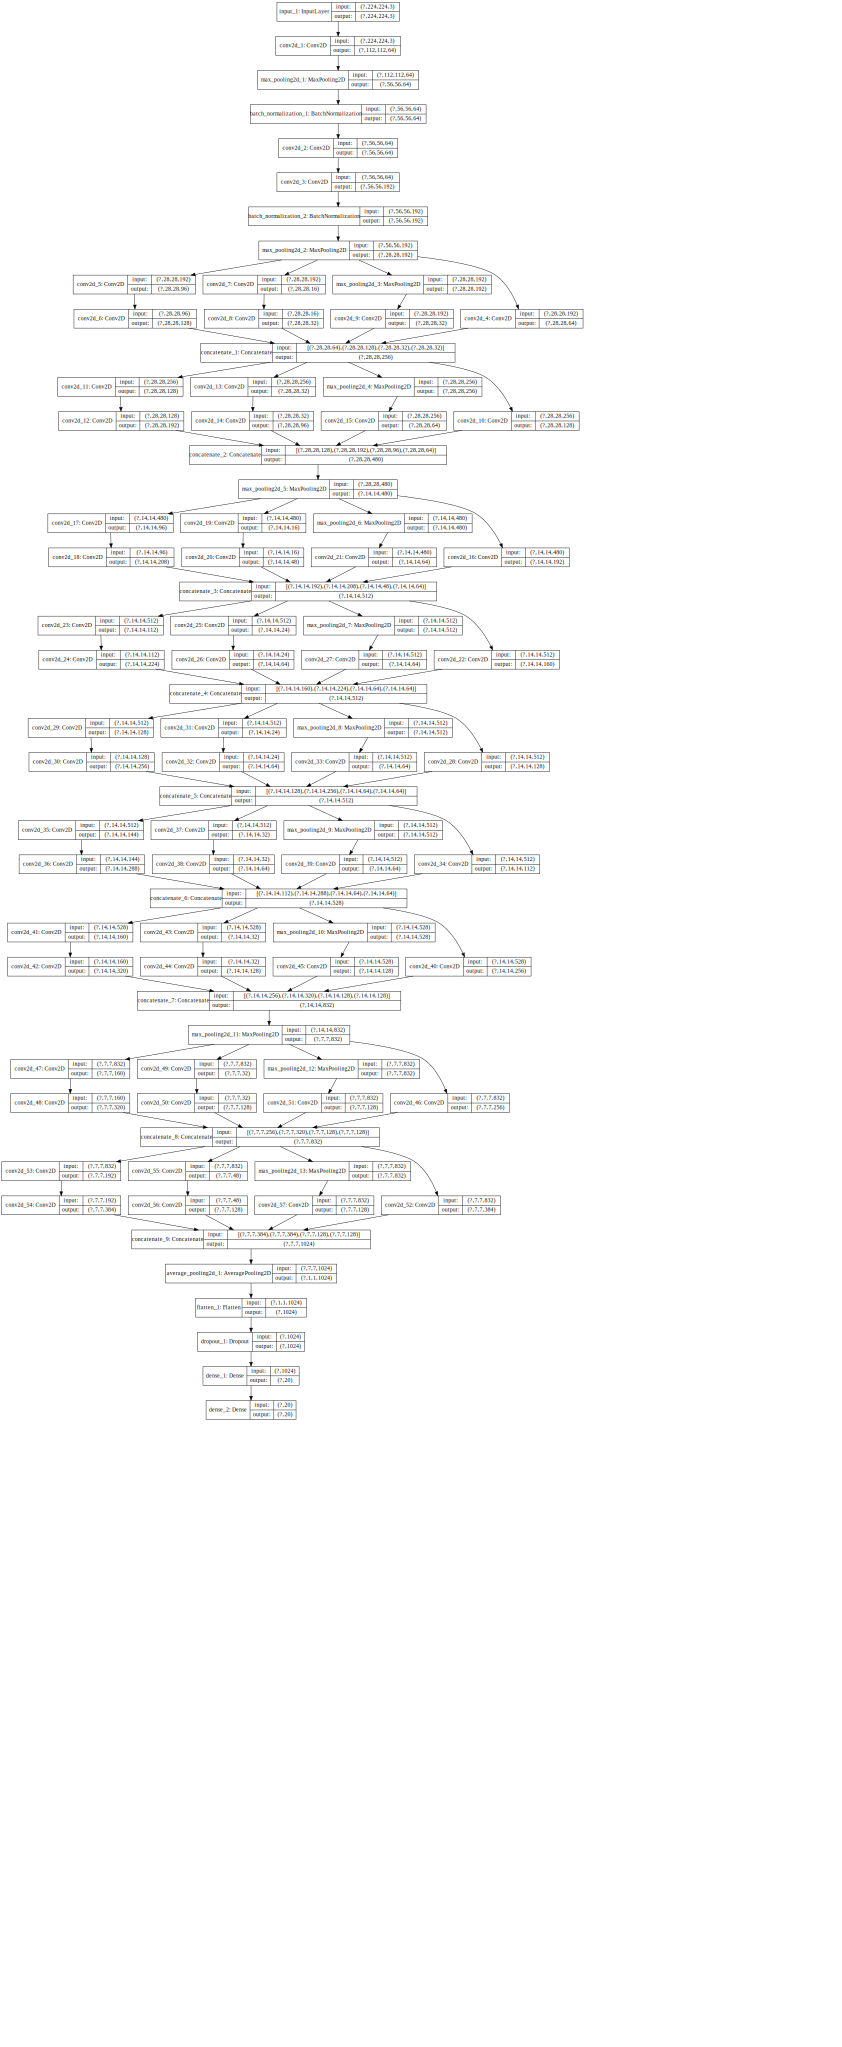

In [5]:
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
SVG(model_to_dot(model,dpi=50,show_shapes=True).create(prog='dot', format='svg'))
